In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error

In [3]:
DATA_DIR = pathlib.Path(".")
DATA_FILE = "sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
RS = 82736

# Загрузка данных

In [4]:
data = pd.read_csv(DATA_DIR.joinpath(DATA_FILE), parse_dates=["month", "date"])

In [5]:
data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
material_code         92306 non-null int64
company_code          92306 non-null int64
country               92306 non-null object
region                92306 non-null object
manager_code          92306 non-null int64
month                 92306 non-null datetime64[ns]
material_lvl1_name    92306 non-null object
material_lvl2_name    92306 non-null object
material_lvl3_name    92306 non-null object
contract_type         92306 non-null object
date                  92306 non-null datetime64[ns]
volume                92306 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


Временной диапазон тренировочного множества:

In [7]:
data.month.min(), data.month.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

# Временные ряды

In [8]:
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)

In [9]:
group_ts

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942               20.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              260.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              240.0   
133           0            Белоруссия Минская обл.       10942              200.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
98

In [10]:
group_ts.index[0]

(124, 7278, 'Россия', 'Респ. Татарстан', 17460)

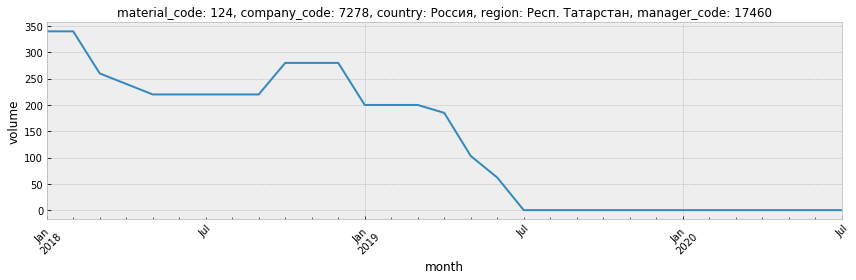

In [11]:
ROW_ID = 0

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

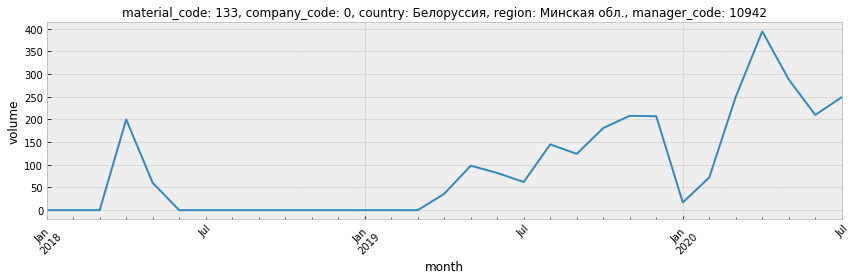

In [12]:
ROW_ID = 1

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

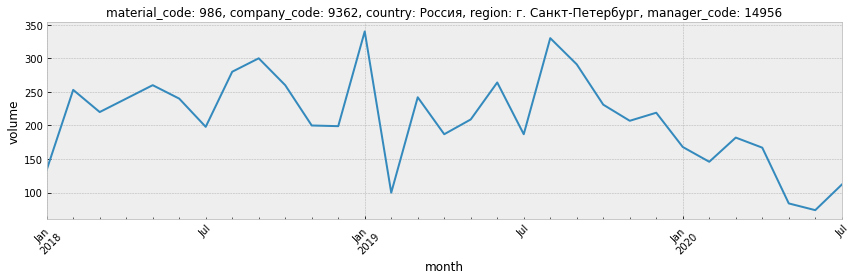

In [13]:
ROW_ID = -7

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

# Baseline #1: последнее известное значение

In [14]:
tr_data = group_ts.iloc[:, :-6]
val_data = group_ts.iloc[:, -6:]

In [15]:
val_data

month                                                                  2020-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               72.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               50.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460               21.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               74.0   
              5410         Россия     г. Санкт-Петербург 14956              180.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2020-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942              250.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               40.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460               63.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956              122.0   
              5410         Россия     г. Санкт-Петербург 14956              180.0   
              6346         Россия     Респ. Башкортостан 10737               20.0   

month                                                                  2020-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942              394.0   
                                      Могилевская обл.   10942              166.0   
                                      г. Минск           10942               21.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460              125.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956              100.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2020-05-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942              288.0   
                                      Могилевская обл.   10942               62.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
98

In [16]:
predictions = val_data.copy()
predictions.iloc[:, :] = np.nan
predictions.iloc[:, 0] = tr_data.iloc[:, -1]

In [17]:
predictions.ffill(axis=1, inplace=True)

In [18]:
predictions

month                                                                  2020-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2020-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2020-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                5.0   
              3380         Россия     Ленинградская обл. 14956               73.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737               40.0   

month                                                                  2020-05-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460                0.0   
133           0            Белоруссия Минская обл.       10942               17.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
98

In [19]:
print("Ошибка на валидационном множестве:", f"{np.sqrt(mean_squared_log_error(val_data, predictions)):.4f}")

Ошибка на валидационном множестве: 2.3817


# Baseline #2: среднее за последние три месяца

In [20]:
predictions = val_data.copy()
predictions.iloc[:, :] = np.nan
predictions.iloc[:, 0] = tr_data.iloc[:, -3:].mean(axis=1)

In [21]:
predictions.ffill(axis=1, inplace=True)

In [22]:
predictions

month                                                                  2020-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2020-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2020-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460           0.000000   
998           0            Россия     Ленинградская обл. 18079           3.666667   
              3380         Россия     Ленинградская обл. 14956          68.000000   
              5410         Россия     г. Санкт-Петербург 14956         113.333333   
              6346         Россия     Респ. Башкортостан 10737          40.000000   

month                                                                  2020-05-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460           0.000000   
133           0            Белоруссия Минская обл.       10942         144.000000   
                                      Могилевская обл.   10942           0.000000   
                                      г. Минск           10942          14.000000   
                           Казахстан  г. Нур-Султан      13301          31.666667   
...                                                                           ...   
98

In [23]:
print("Ошибка на валидационном множестве:", f"{np.sqrt(mean_squared_log_error(val_data, predictions)):.4f}")

Ошибка на валидационном множестве: 2.2008


# Baseline #3: CatBoostRegressor

Признаки:

- оригинальные категориальные признаки,
- месяц, для которого предсказываем,
- среднее, минимум и максимум за год,
- последние 6 месяцев до месяца, для которого предсказываем.

Для тренировки будем использовать период `2019-01-01` по `2019-06-01`, для валидации: с `2019-07-01` по `2019-12-01`, для тестирования: с `2020-01-01` по `2020-07-01`.

In [24]:
def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Calculate features for `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_year_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_year_max"))
    features["month"] = month.month
    return features

In [25]:
tr_range = pd.date_range("2019-01-01", "2019-06-01", freq="MS")
val_range = pd.date_range("2019-07-01", "2019-12-01", freq="MS")
ts_range = pd.date_range("2020-01-01", "2020-07-01", freq="MS")

In [26]:
full_features = {}

for dataset, dataset_range in zip(["tr", "val", "ts"], [tr_range, val_range, ts_range]):
    dataset_features = []
    for target_month in dataset_range:
        features = get_features(group_ts, target_month)
        features["target"] = group_ts[target_month]
        dataset_features.append(features.reset_index())
    full_features[dataset] = pd.concat(dataset_features, ignore_index=True)

## Тренировка

In [27]:
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month",
            "vol_tm6", "vol_tm5", "vol_tm4", "vol_tm3", "vol_tm2", "vol_tm1",
            "last_year_avg", "last_year_min", "last_year_max"]
TARGET = "target"

In [28]:
model = CatBoostRegressor(iterations=1000,
                          early_stopping_rounds=30,
                          depth=6,
                          cat_features=CAT_COLS,
                          random_state=RS,
                          verbose=10)
model.fit(full_features["tr"][FTS_COLS], full_features["tr"][TARGET],
          eval_set=(full_features["val"][FTS_COLS], full_features["val"][TARGET]))

Learning rate set to 0.06391
0:	learn: 297.7980042	test: 309.3496233	best: 309.3496233 (0)	total: 315ms	remaining: 5m 14s
10:	learn: 201.6350934	test: 235.1154757	best: 235.1154757 (10)	total: 1.17s	remaining: 1m 45s
20:	learn: 150.7647323	test: 198.8471658	best: 198.8471658 (20)	total: 1.92s	remaining: 1m 29s
30:	learn: 124.7939106	test: 184.9496987	best: 184.9496987 (30)	total: 2.6s	remaining: 1m 21s
40:	learn: 110.7861788	test: 179.2058068	best: 179.2058068 (40)	total: 3.37s	remaining: 1m 18s
50:	learn: 102.7139106	test: 178.1757158	best: 178.1425053 (49)	total: 4.18s	remaining: 1m 17s
60:	learn: 98.3566054	test: 178.0438067	best: 178.0091598 (58)	total: 4.96s	remaining: 1m 16s
70:	learn: 96.0366179	test: 178.2787217	best: 178.0091598 (58)	total: 5.69s	remaining: 1m 14s
80:	learn: 93.8689756	test: 178.1929607	best: 177.9991318 (77)	total: 6.49s	remaining: 1m 13s
90:	learn: 91.9057688	test: 178.3481312	best: 177.9991318 (77)	total: 7.16s	remaining: 1m 11s
100:	learn: 90.5709259	test:

In [29]:
pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

vol_tm1          38.505076
vol_tm2          20.492027
last_year_max    11.728990
last_year_avg    10.626870
vol_tm3           7.154417
vol_tm4           3.045585
last_year_min     2.612081
country           2.292897
vol_tm5           1.162598
vol_tm6           1.136612
month             0.764280
material_code     0.276903
region            0.118152
manager_code      0.083512
company_code      0.000000
dtype: float64

In [30]:
tr_preds = model.predict(full_features["tr"][FTS_COLS])
val_preds = model.predict(full_features["val"][FTS_COLS])
ts_preds = model.predict(full_features["ts"][FTS_COLS])

In [31]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(full_features["tr"][TARGET], tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(full_features["val"][TARGET], val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(full_features["ts"][TARGET], ts_preds)):.4f}')

Ошибка на тренировочном множестве: 2.0715
Ошибка на валидационном множестве: 1.9757
Ошибка на тестовом множестве: 2.1844


# Формирование загрузки

In [32]:
model.save_model("baseline_model.cbm")

In [33]:
%%writefile predict.py

import pathlib
import pandas as pd
from catboost import CatBoostRegressor

MODEL_FILE = pathlib.Path(__file__).parent.joinpath("baseline_model.cbm")
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    start_period = month - pd.offsets.MonthBegin(6)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    features[[f"vol_tm{i}" for i in range(6, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_year_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_year_max"))
    features["month"] = month.month
    return features.reset_index()


def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    group_ts = df.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    features = get_features(group_ts, month)

    model = CatBoostRegressor()
    model.load_model(MODEL_FILE)
    predictions = model.predict(features[model.feature_names_])

    preds_df = features[AGG_COLS].copy()
    preds_df["prediction"] = predictions
    return preds_df
    

Writing predict.py


Протестируем:

In [34]:
import predict

In [35]:
predict.get_features(group_ts.iloc[:, :-1], pd.Timestamp("2020-07-01"))

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max
0,124,7278,Россия,Респ. Татарстан,17460,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,133,0,Белоруссия,Минская обл.,10942,7,17.0,72.0,250.0,394.0,288.0,210.0,179.833333,17.0,394.0
2,133,0,Белоруссия,Могилевская обл.,10942,7,0.0,0.0,0.0,166.0,62.0,0.0,19.000000,0.0,166.0
3,133,0,Белоруссия,г. Минск,10942,7,0.0,0.0,0.0,21.0,0.0,0.0,22.416667,0.0,83.0
4,133,0,Казахстан,г. Нур-Султан,13301,7,0.0,50.0,40.0,0.0,0.0,50.0,30.000000,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,7,0.0,21.0,63.0,125.0,84.0,84.0,31.416667,0.0,125.0
937,998,0,Россия,Ленинградская обл.,18079,7,5.0,5.0,5.0,0.0,3.0,3.0,4.750000,0.0,10.0
938,998,3380,Россия,Ленинградская обл.,14956,7,73.0,74.0,122.0,100.0,15.0,30.0,85.583333,15.0,129.0
939,998,5410,Россия,г. Санкт-Петербург,14956,7,100.0,180.0,180.0,100.0,140.0,40.0,118.333333,40.0,180.0


In [37]:
predict.predict(data[data.month<"2020-07-01"], pd.Timestamp("2020-07-01"))

,material_code,company_code,country,region,manager_code,prediction
0,124,7278,Россия,Респ. Татарстан,17460,19.492145
1,133,0,Белоруссия,Минская обл.,10942,219.405064
2,133,0,Белоруссия,Могилевская обл.,10942,38.752669
3,133,0,Белоруссия,г. Минск,10942,21.810030
4,133,0,Казахстан,г. Нур-Султан,13301,28.517821
...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,70.188998
937,998,0,Россия,Ленинградская обл.,18079,15.094203
938,998,3380,Россия,Ленинградская обл.,14956,48.621560
939,998,5410,Россия,г. Санкт-Петербург,14956,98.563337


In [40]:
!zip -r baseline_submission1.zip baseline_model.cbm predict.py

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [41]:
!DIR

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 0AF6-60B7

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\rniva\Desktop\Sibur2021

24.11.2021  00:08    <DIR>          .
24.11.2021  00:08    <DIR>          ..
23.11.2021  23:02    <DIR>          .ipynb_checkpoints
24.11.2021  00:04           129я824 baseline_model.cbm
23.11.2021  22:55            51я241 baseline_submission.zip
24.11.2021  00:04    <DIR>          catboost_info
24.11.2021  00:04             2я384 predict.py
23.11.2021  22:55        14я322я235 sc2021_train_deals.csv
23.11.2021  22:55             6я003 Sibur2021.ipynb
24.11.2021  00:08           251я934 [SC2021] Baseline.ipynb
24.11.2021  00:04    <DIR>          __pycache__
               6 д ©«®ў     14я763я621 Ў ©в
               5 Ї Ї®Є  644я394я348я544 Ў ©в бў®Ў®¤­®
